In [7]:
%matplotlib inline
import pandas as pd
import numpy as np
import joblib as jl
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

root = 'dl'

# Load raw data

In [8]:
labels = pd.read_csv('../../tmp/1_METONLY_vs_METX/matched_CEM_table.csv', header=0).rename({'Unnamed: 0': 'PIN'}, axis=1)[['PIN', 'CLASS']].set_index('PIN')
labels.head()

,CLASS
PIN,
568483,1
923748,0
2035328,0
2239386,1
2244533,1


In [9]:
data = jl.load(open('../../tmp/item_days_raw_data_.pkl', 'rb')).loc[labels.index, 'seq']
df = pd.DataFrame(columns=['Seq', 'Class'], index=data.index)
df.loc[:, 'Seq'] = data
df.loc[:, 'Class'] = labels['CLASS']
df.head()

,Seq,Class
PIN,,
568483,10990 0 23 16 725 0 10990 0 10990 0 10990 0 10...,1
923748,66653 0 65070 0 66515 5 10962 1 105 1 56807 42...,0
2035328,66536 0 74995 0 66512 0 66551 0 66608 0 66716 ...,0
2239386,10991 0 23 105 73928 0 66560 0 66515 0 66551 0...,1
2244533,10990 0 23 74 23 0 10990 1 73928 0 66500 0 665...,1


# Separate MBS items and timepoints

In [10]:
for idx in df.index:
    _tmp = df.loc[idx, 'Seq'].split(' ')
    df.loc[idx, 'mbs_seq'] = ' '.join(_tmp[::2])
    df.loc[idx, 'times_seq'] = ' '.join(_tmp[1::2])

In [11]:
df.head()

,Seq,Class,mbs_seq,times_seq
PIN,,,,
568483,10990 0 23 16 725 0 10990 0 10990 0 10990 0 10...,1,10990 23 725 10990 10990 10990 10993 23 85311 ...,0 16 0 0 0 0 0 15 0 0 13 0 0 0 22 0 0 0 0 0 0 ...
923748,66653 0 65070 0 66515 5 10962 1 105 1 56807 42...,0,66653 65070 66515 10962 105 56807 10990 23 109...,0 0 5 1 1 42 0 26 35 0 0 0 9 0 0 0 5 0 0 0 21 ...
2035328,66536 0 74995 0 66512 0 66551 0 66608 0 66716 ...,0,66536 74995 66512 66551 66608 66716 66560 7392...,0 0 0 0 0 0 0 9 1 10 9 138 1 3 31 24 63 0 0 0 ...
2239386,10991 0 23 105 73928 0 66560 0 66515 0 66551 0...,1,10991 23 73928 66560 66515 66551 66536 2517 10...,0 105 0 0 0 0 4 2 27 1 1 7 0 18 132 0 0 0 1 0 ...
2244533,10990 0 23 74 23 0 10990 1 73928 0 66500 0 665...,1,10990 23 23 10990 73928 66500 66560 66551 23 1...,0 74 0 1 0 0 0 2 0 87 0 1 0 0 0 0 0 2 0 6 0 8 ...


# Seq2Tokens

In [12]:
# Define tokenizer object
tokenizer = Tokenizer(char_level=False, lower=False, split=' ')

# Fit on corpus and extract tokenized sequences
tokenizer.fit_on_texts(df['mbs_seq'])
n_feat = len(tokenizer.word_index.keys())
print(n_feat)
seq = tokenizer.texts_to_sequences(df['mbs_seq'])

# Pad tokenized sequences
lengths = [len(x) for x in seq]
maxlen = int(np.percentile(lengths, 95))
p_seq = pad_sequences(seq, maxlen=maxlen)
print(p_seq.shape)

# Pad timestamps
t_seq = [map(int, df.loc[idx, 'times_seq'].split(' ')) for idx in df.index]
p_t_seq = pad_sequences(t_seq, maxlen=maxlen)
print(p_t_seq.shape)

2773
(11744, 445)
(11744, 445)


# Training - Validation - Test split

In [13]:
# Full dataset
y = df['Class'].ravel()
X = p_seq
X_t = p_t_seq

# Learn / Test
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=0)
learn_idx, test_idx = next(sss.split(X, y))

X_learn, y_learn = X[learn_idx, :], y[learn_idx]
X_test, y_test = X[test_idx, :], y[test_idx]

X_learn_t = X_t[learn_idx, :]
X_test_t = X_t[test_idx, :]

print('{} learn / {} test'.format(len(y_learn), len(y_test)))

# Training / Validation
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=1)
train_idx, valid_idx = next(sss.split(X_learn, y_learn))

X_train, y_train = X_learn[train_idx, :], y_learn[train_idx]
X_valid, y_valid = X_learn[valid_idx, :], y_learn[valid_idx]

X_train_t = X_learn_t[train_idx, :]
X_valid_t = X_learn_t[valid_idx, :]

print('{} training / {} validation'.format(len(y_train), len(y_valid)))

5872 learn / 5872 test
5284 training / 588 validation


# Init embedding matrix

In [55]:
D = 200
embedding = pd.read_csv('../../tmp/embedding.{}d.csv'.format(D), header=0, index_col=0)
embedding_matrix = embedding.values

# Model

In [56]:
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input, Dense, Flatten
from keras.layers import Embedding
from keras.layers import CuDNNLSTM, LSTM
from keras.layers import Conv1D
from keras.layers import Dropout
from keras.layers import Multiply, merge
from keras.layers import Permute, Reshape, RepeatVector
from keras.layers.core import K

In [68]:
def build_model(mbs_input_shape, timestamp_input_shape):
    # Channel 1: MBS
    mbs_input = Input(shape=mbs_input_shape, name='mbs_input')
    x1 = Embedding(n_feat, D, name='mbs_embedding')(mbs_input)
    x1 = CuDNNLSTM(32, return_sequences=True, name='mbs_lstm')(x1)
    
    # -- Attention -- #
    # Channel 2: Timestamps
    timestamp_input = Input(shape=timestamp_input_shape, name='timestamp_input')
    x2 = Conv1D(32, 3, activation='relu', padding='causal', name='timestamp_conv1d')(timestamp_input)
    x2 = CuDNNLSTM(32, return_sequences=True, name='timestamp_lstm')(x2)
    x2 = Permute((2, 1), name='transpose_timestamp')(x2)
    x2 = Dense(mbs_input_shape[0], activation='linear', name='timestamp_dense')(x2)
    
    alpha = Permute((2, 1), name='hidden_to_time_permute')(x1)
    alpha = Multiply(name='timestamp_induced_attention')([alpha, x2])
    alpha = Dense(mbs_input_shape[0], activation='softmax', name='attention_probabilities')(alpha)
    alpha = Permute((2, 1), name='time_to_hidden_permute')(alpha)
    # -- Attention -- #
    
    
    # Combine channels to get context
    context = Multiply(name='context_creation')([alpha, x1])
    
    # Output
#     x = Flatten()(context)
#     x = Dense(128, activation='relu')(x)
#     x = Dropout(0.25)(x)
    x = LSTM(32, name='top_lstm', recurrent_dropout=0.5, dropout=0.5)(context)
    output = Dense(1, activation='sigmoid')(x)
    
    # Define the model
    model = Model(inputs=[mbs_input, timestamp_input],
                  outputs=[output])
    return model


model = build_model(mbs_input_shape=(maxlen,),
                    timestamp_input_shape=(maxlen, 1))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
timestamp_input (InputLayer)    (None, 445, 1)       0                                            
__________________________________________________________________________________________________
mbs_input (InputLayer)          (None, 445)          0                                            
__________________________________________________________________________________________________
timestamp_conv1d (Conv1D)       (None, 445, 32)      128         timestamp_input[0][0]            
__________________________________________________________________________________________________
mbs_embedding (Embedding)       (None, 445, 200)     554600      mbs_input[0][0]                  
__________________________________________________________________________________________________
timestamp_

In [69]:
# model.load_weights('model.h5')
model.get_layer('mbs_embedding').set_weights([embedding_matrix])
model.get_layer('mbs_embedding').trainable = True

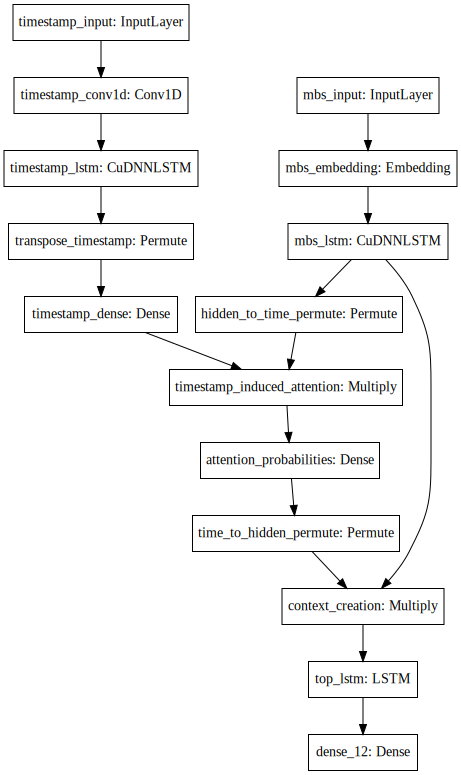

In [70]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [71]:
from keras.callbacks import EarlyStopping
callbacks = [EarlyStopping(monitor='val_loss', patience=7)] 

history = model.fit([X_train, X_train_t.reshape(len(y_train), maxlen, 1)], y_train,
                    epochs=100,
                    callbacks=callbacks,
                    batch_size=128,
                    validation_data=([X_valid, X_valid_t.reshape(len(y_valid), maxlen, 1)],
                                     y_valid))

Train on 5284 samples, validate on 588 samples
Epoch 1/100
5284/5284 [==============================] - 41s 8ms/step - loss: 0.6933 - acc: 0.4909 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 2/100
5284/5284 [==============================] - 39s 7ms/step - loss: 0.6931 - acc: 0.5042 - val_loss: 0.6927 - val_acc: 0.5340
Epoch 3/100
5284/5284 [==============================] - 39s 7ms/step - loss: 0.6721 - acc: 0.5984 - val_loss: 0.6184 - val_acc: 0.6735
Epoch 4/100
5284/5284 [==============================] - 39s 7ms/step - loss: 0.6115 - acc: 0.6800 - val_loss: 0.5793 - val_acc: 0.7007
Epoch 5/100
5284/5284 [==============================] - 38s 7ms/step - loss: 0.5790 - acc: 0.7120 - val_loss: 0.5445 - val_acc: 0.7313
Epoch 6/100
5284/5284 [==============================] - 38s 7ms/step - loss: 0.5559 - acc: 0.7252 - val_loss: 0.5403 - val_acc: 0.7398
Epoch 7/100
5284/5284 [==============================] - 39s 7ms/step - loss: 0.5152 - acc: 0.7610 - val_loss: 0.5934 - val_acc: 0.6990
E

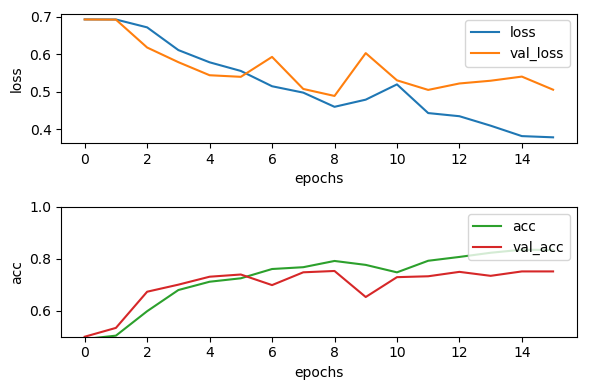

In [72]:
plt.figure(dpi=100)
t = history.epoch

plt.subplot(211)
plt.plot(t, history.history['loss'], label='loss', color='C0')
plt.plot(t, history.history['val_loss'], label='val_loss', color='C1')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc=1)

plt.subplot(212)
plt.plot(t, history.history['acc'], label='acc', color='C2')
plt.plot(t, history.history['val_acc'], label='val_acc', color='C3')
plt.ylim([0.5, 1])
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(loc=1)

plt.tight_layout()

In [73]:
y_pred = model.predict([X_test, X_test_t.reshape(len(y_test), maxlen, 1)]).ravel()

In [74]:
loss = metrics.log_loss(y_test, y_pred)
acc = metrics.accuracy_score(y_test, y_pred > 0.5)
prec = metrics.precision_score(y_test, y_pred > 0.5)
rcll = metrics.recall_score(y_test, y_pred > 0.5)
auc = metrics.roc_auc_score(y_test, y_pred)
print('Test scores:\n * Log-Loss\t{}\n * Accuracy:\t{}\n '
      '* Precision:\t{}\n * Recall:\t{}\n * AUC: \t{}'.format(loss, acc, prec, rcll, auc))

Test scores:
 * Log-Loss	0.526277360537
 * Accuracy:	0.746083106267
 * Precision:	0.77650210486
 * Recall:	0.691076294278
 * AUC: 	0.830410531391


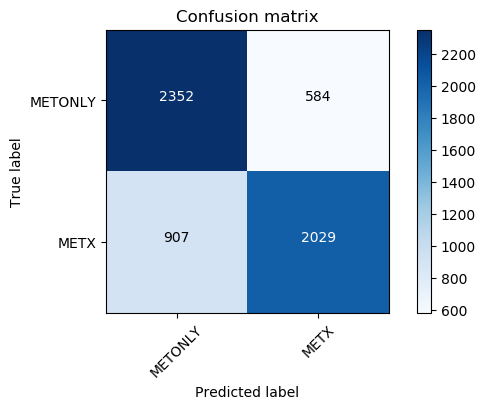

In [75]:
# Plot non-normalized confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred > 0.5)
plt.figure(dpi=100)
plot_confusion_matrix(cnf_matrix, classes=['METONLY', 'METX'],
                      title='Confusion matrix', cmap=plt.cm.Blues);

In [ ]:
# model.save_weights('model.h5')

In [15]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return plt